In [1]:
# ===================================================================
# Part 0: Import Libraries and Setup
# ===================================================================
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score

# Classical Time Series
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

# Deep Learning with TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Plotting
import matplotlib.pyplot as plt

# Settings
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported and setup complete.")

Libraries imported and setup complete.


In [7]:
# ===================================================================
# Part 1: Data Retrieval & Shared Preparation
# ===================================================================
# --- Configuration ---
STOCK_TICKER = 'AAPL' # Apple Inc.
START_DATE = '2015-01-01'
END_DATE = '2025-08-22' # Using current date as end
TRAIN_TEST_SPLIT_RATIO = 0.9

# --- Data Loading ---
print(f"\nDownloading stock data for {STOCK_TICKER}...")
data = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)



# --- Feature Engineering ---
data['Price_Up'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
data = data.iloc[:-1]

print("Data downloaded and prepared:")
print(data.head())

# --- Train/Test Split ---
split_index = int(len(data) * TRAIN_TEST_SPLIT_RATIO)
train_data = data[:split_index]
test_data = data[split_index:]

print(f"\nTraining set size: {len(train_data)} days")
print(f"Testing set size: {len(test_data)} days")

C:\Users\udbha\AppData\Local\Temp\ipykernel_19716\3159357405.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed

Data downloaded and prepared:
Price           Close       High        Low       Open     Volume Price_Up
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL         
Date                                                                      
2015-01-02  24.261047  24.729270  23.821672  24.718174  212818400        0
2015-01-05  23.577574  24.110150  23.391173  24.030263  257142000        1
2015-01-06  23.579794  23.839424  23.218085  23.641928  263188400        1
2015-01-07  23.910439  24.010296  23.677436  23.788389  160423600        1
2015-01-08  24.829126  24.886823  24.121244  24.238856  237458000        1

Training set size: 2406 days
Testing set size: 268 days


In [3]:
# ===================================================================
# Path A: The Classical Time Series Approach (ARIMA & GARCH)
# ===================================================================
print("\n--- Starting Path A: Classical Time Series (ARIMA/GARCH) ---")

# --- Stationarity Check (ADF Test) ---
# ARIMA requires the time series to be stationary.
adf_result = adfuller(train_data['Close'])
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
# A p-value > 0.05 suggests the data is non-stationary. Differencing is needed.

# --- Auto-ARIMA to find best parameters ---
print("\nFinding best ARIMA model parameters using auto_arima...")
# We let auto_arima find the optimal p, d, q parameters
auto_arima_model = pm.auto_arima(
    train_data['Close'],
    start_p=1, start_q=1,
    test='adf',       # use adf test to find optimal 'd'
    max_p=5, max_q=5, # maximum p and q
    m=1,              # frequency of series (1 for daily)
    d=None,           # let model determine 'd'
    seasonal=False,   # no seasonality for daily stock data
    start_P=0,
    D=0,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print("\nAuto-ARIMA Summary:")
print(auto_arima_model.summary())


--- Starting Path A: Classical Time Series (ARIMA/GARCH) ---
ADF Statistic: 0.3301
p-value: 0.9787

Finding best ARIMA model parameters using auto_arima...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9850.999, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9847.448, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9848.560, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9848.517, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9849.812, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.641 seconds

Auto-ARIMA Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2406
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4921.724
Date:                Fri, 22 Aug 2025   AIC                           9847.448
Time:                        04:37:37   BIC             

In [11]:
train_data.columns = train_data.columns.get_level_values(0)
test_data.columns = train_data.columns.get_level_values(0)


# Force Close column to numeric, dropping anything non-numeric
train_data['Close'] = pd.to_numeric(train_data['Close'], errors='coerce')
test_data['Close'] = pd.to_numeric(test_data['Close'], errors='coerce')

# Drop rows where Close became NaN (i.e., was string or invalid)
train_data = train_data.dropna(subset=['Close'])
test_data = test_data.dropna(subset=['Close'])

# Reset index after dropping
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# --- Walk-Forward Validation for ARIMA ---
print("\nPerforming Walk-Forward Validation for ARIMA...")
history = list(train_data['Close'])
predictions_arima = []
# This loop can be slow as it re-fits the model each day
for t in range(len(test_data)):
    model = pm.ARIMA(order=auto_arima_model.order)
    model_fit = model.fit(history)
    yhat = model_fit.predict(n_periods=1)[0]
    predictions_arima.append(yhat)
    history.append(test_data['Close'].iloc[t])

# --- GARCH for Volatility ---
# Use the residuals from the main ARIMA model to fit GARCH
residuals = auto_arima_model.resid()
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp="off")
print("\nGARCH Model Summary:")
print(garch_fit.summary())

C:\Users\udbha\AppData\Local\Temp\ipykernel_19716\2786339564.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Close'] = pd.to_numeric(train_data['Close'], errors='coerce')
C:\Users\udbha\AppData\Local\Temp\ipykernel_19716\2786339564.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Close'] = pd.to_numeric(test_data['Close'], errors='coerce')



Performing Walk-Forward Validation for ARIMA...

GARCH Model Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3758.00
Distribution:                  Normal   AIC:                           7524.00
Method:            Maximum Likelihood   BIC:                           7547.14
                                        No. Observations:                 2406
Date:                Fri, Aug 22 2025   Df Residuals:                     2405
Time:                        04:57:44   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------

In [13]:
# --- Evaluate ARIMA ---
arima_rmse = np.sqrt(mean_squared_error(test_data['Close'], predictions_arima))
# Convert price predictions to directional signals
arima_direction_preds = [1 if pred > test_data['Close'].iloc[i-1] else 0 for i, pred in enumerate(predictions_arima, 1) if i < len(test_data)]
# Align actuals for comparison
actual_direction = test_data['Price_Up'].iloc[1:len(arima_direction_preds)+1]
arima_accuracy = accuracy_score(actual_direction, arima_direction_preds)

print("\n--- Path A: ARIMA/GARCH Results ---")
print(f"ARIMA Price Prediction RMSE: {arima_rmse:.4f}")
print(f"ARIMA Directional Accuracy: {arima_accuracy:.4f}")


--- Path A: ARIMA/GARCH Results ---
ARIMA Price Prediction RMSE: 4.1322
ARIMA Directional Accuracy: 0.4569


In [14]:
# ===================================================================
# Path B: The Deep Learning Approach (LSTM)
# ===================================================================
print("\n\n--- Starting Path B: Deep Learning (LSTM) ---")

# --- Data Preparation for LSTM ---
# We'll use 'Close' and 'Volume' as features
features = ['Close', 'Volume']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features])

def create_sequences(data, lookback_period):
    X, y = [], []
    for i in range(lookback_period, len(data)):
        X.append(data[i-lookback_period:i])
        y.append(data[i, 0]) # We predict the 'Close' price
    return np.array(X), np.array(y)

LOOKBACK_PERIOD = 60 # Use last 60 days of data to predict the next day
X, y = create_sequences(scaled_data, LOOKBACK_PERIOD)

# Split into train and test sets for LSTM
X_train, X_test = X[:split_index-LOOKBACK_PERIOD], X[split_index-LOOKBACK_PERIOD:]
y_train, y_test = y[:split_index-LOOKBACK_PERIOD], y[split_index-LOOKBACK_PERIOD:]

# Align y_test with the original test_data for comparison
y_test_actual_price = test_data['Close'][LOOKBACK_PERIOD:]

print(f"\nLSTM Train/Test shapes: {X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")



--- Starting Path B: Deep Learning (LSTM) ---

LSTM Train/Test shapes: (2346, 60, 2), (268, 60, 2), (2346,), (268,)


In [15]:
# --- Building the LSTM Model ---
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1) # Output is a single value (the predicted price)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
print("\nLSTM Model Summary:")
lstm_model.summary()


C:\Users\udbha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,101 (125.39 KB)

 Trainable params: 32,101 (125.39 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# --- Training the LSTM Model ---
print("\nTraining LSTM model...")
lstm_model.fit(X_train, y_train, batch_size=32, epochs=25, verbose=1)

# --- Making Predictions with LSTM ---
predictions_lstm_scaled = lstm_model.predict(X_test)
dummy_array = np.zeros((len(predictions_lstm_scaled), len(features)))
dummy_array[:, 0] = predictions_lstm_scaled.ravel()
predictions_lstm = scaler.inverse_transform(dummy_array)[:, 0]

# --- Evaluate LSTM ---
# FIX STARTS HERE: Use a DataFrame for robust alignment and calculation
# 1. Define the actual prices for the test period. This should be the full 'Close' column.
y_test_actual_price = test_data['Close']

# 2. Create a results DataFrame
results_df = pd.DataFrame({
    'Actual_Close': y_test_actual_price.values,
    'LSTM_Prediction': predictions_lstm,
    'Actual_Direction': test_data['Price_Up'].values
}, index=y_test_actual_price.index)

# 3. Calculate predicted direction by comparing to the PREVIOUS day's ACTUAL close
results_df['Predicted_Direction'] = np.where(results_df['LSTM_Prediction'] > results_df['Actual_Close'].shift(1), 1, 0)

# 4. Drop the first row which has a NaN for the shifted value
results_df.dropna(inplace=True)

# 5. Calculate metrics from the aligned DataFrame
lstm_rmse = np.sqrt(mean_squared_error(results_df['Actual_Close'], results_df['LSTM_Prediction']))
lstm_accuracy = accuracy_score(results_df['Actual_Direction'], results_df['Predicted_Direction'])
# FIX ENDS HERE

print("\n--- Path B: LSTM Results ---")
print(f"LSTM Price Prediction RMSE: {lstm_rmse:.4f}")
print(f"LSTM Directional Accuracy: {lstm_accuracy:.4f}")


Training LSTM model...
Epoch 1/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 6.8751e-04
Epoch 2/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 6.6185e-04
Epoch 3/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 6.2278e-04
Epoch 4/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.1337e-04
Epoch 5/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.3076e-04
Epoch 6/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.6521e-04
Epoch 7/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.3404e-04
Epoch 8/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.9418e-04
Epoch 9/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.1319e-04
Epoch 10/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.9122e-04
Epoch 11/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 6.8571e-04
Epoch 12/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.5378e-04
Epoch 13/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.7519e-04
Epoch 14/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.

In [18]:
# ===================================================================
# Part 4: Final Comparison
# ===================================================================
print("\n\n================================================")
print("          Final Model Comparison          ")
print("================================================")
print(f"Stock Ticker: {STOCK_TICKER}")
print("------------------------------------------------")
print("  Metric                      |  ARIMA   |  LSTM  ")
print("------------------------------------------------")
print(f"Price Prediction RMSE         | {arima_rmse:^8.4f} | {lstm_rmse:^6.4f}")
print(f"Directional Accuracy          | {arima_accuracy:^8.4f} | {lstm_accuracy:^6.4f}")
print("================================================\n")



          Final Model Comparison          
Stock Ticker: AAPL
------------------------------------------------
  Metric                      |  ARIMA   |  LSTM  
------------------------------------------------
Price Prediction RMSE         |  4.1322  | 6.9924
Directional Accuracy          |  0.4569  | 0.4515



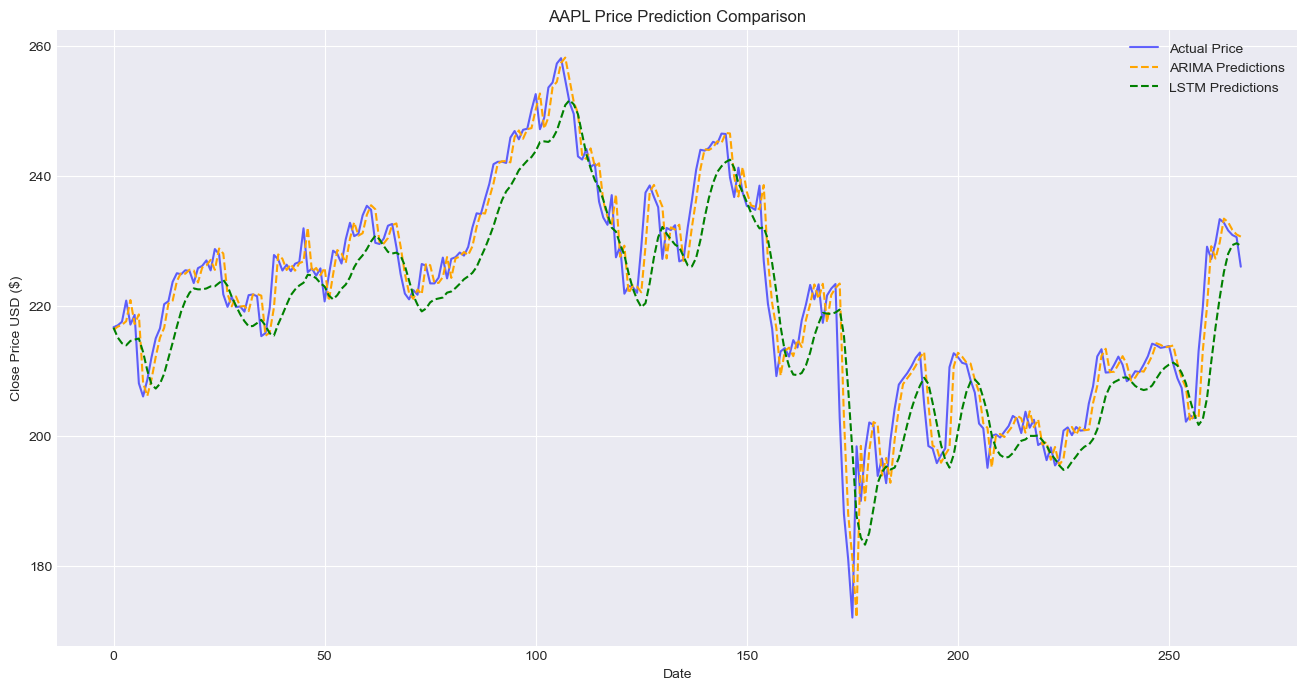

In [20]:
# ===================================================================
# Part 5: Visualization
# ===================================================================
plt.figure(figsize=(16, 8))
plt.title(f'{STOCK_TICKER} Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(test_data.index, test_data['Close'], label='Actual Price', color='blue', alpha=0.6)
plt.plot(test_data.index, predictions_arima, label='ARIMA Predictions', color='orange', linestyle='--')
# Align LSTM predictions with the correct dates
plt.plot(results_df.index, results_df['LSTM_Prediction'], label='LSTM Predictions', color='green', linestyle='--')
plt.legend()
plt.show()

In [ ]:
#Now adding more features to data for LSTM model

In [27]:
# ===================================================================
# Part 0: Import Libraries and Setup
# ===================================================================
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score

# Classical Time Series
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

# Deep Learning with TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Plotting
import matplotlib.pyplot as plt
import sys

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
# ===================================================================
# Part 1: Data Retrieval & Feature Engineering
# ===================================================================
# --- Configuration ---
STOCK_TICKER = 'AAPL'
START_DATE = '2015-01-01'
END_DATE = '2025-08-22'
TRAIN_TEST_SPLIT_RATIO = 0.8

# --- Data Loading ---
print(f"\nDownloading stock data for {STOCK_TICKER}...")
data = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)

# --- Robust Check for Download Success ---
if not isinstance(data, pd.DataFrame) or data.empty:
    print(f"Error: Failed to download data for {STOCK_TICKER}.")
    sys.exit()
else:
    print("Data downloaded successfully.")

data.columns = data.columns.get_level_values(0)
# --- Data Cleaning ---
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
data.dropna(subset=['Close'], inplace=True)

# --- MODIFICATION STARTS HERE: Add Technical Indicators ---
print("\nCalculating technical indicators...")
# Moving Averages
data.ta.sma(length=20, append=True)
data.ta.ema(length=20, append=True)
# RSI
data.ta.rsi(length=14, append=True)
# MACD
data.ta.macd(append=True)
# Bollinger Bands
data.ta.bbands(length=20, append=True)

# The indicators create NaN values for the first few rows. We must drop them.
data.dropna(inplace=True)
# --- MODIFICATION ENDS HERE ---

# --- Feature Engineering ---
data['Price_Up'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
data = data.iloc[:-1]

print("\nData prepared with new features:")
print(data.head())
print(f"\nTotal columns/features: {len(data.columns)}")

# --- Train/Test Split ---
split_index = int(len(data) * TRAIN_TEST_SPLIT_RATIO)
train_data = data[:split_index]
test_data = data[split_index:]

print(f"\nTraining set size: {len(train_data)} days")
print(f"Testing set size: {len(test_data)} days")

[*********************100%***********************]  1 of 1 completed

Data downloaded successfully.

Calculating technical indicators...

Data prepared with new features:
Price           Close       High        Low       Open     Volume     SMA_20  \
Date                                                                           
2015-02-20  28.850317  28.850317  28.527283  28.654267  195793600  26.877112   
2015-02-23  29.630058  29.630058  28.885966  28.966168  283896400  27.105064   
2015-02-24  29.445141  29.763721  29.222359  29.616684  276912400  27.322440   
2015-02-25  28.692137  29.318158  28.549556  29.309245  298846800  27.546102   
2015-02-26  29.055283  29.155534  28.206482  28.692146  365150000  27.719464   

Price          EMA_20     RSI_14  MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9  \
Date                                                                           
2015-02-20  27.055600  78.737321      1.252471       0.102174       1.150297   
2015-02-23  27.300787  82.379299      1.306287       0.124792       1.181495   
2015-02-24  27.505

In [29]:
# ===================================================================
# Path A: The Classical Time Series Approach (ARIMA & GARCH)
# (This part remains unchanged as ARIMA only uses the 'Close' price)
# ===================================================================
print("\n--- Starting Path A: Classical Time Series (ARIMA/GARCH) ---")
adf_result = adfuller(train_data['Close'])
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
auto_arima_model = pm.auto_arima(train_data['Close'], trace=False, suppress_warnings=True)
print("\nAuto-ARIMA Summary:")
print(auto_arima_model.summary())
history = list(train_data['Close'])
predictions_arima = []
for t in range(len(test_data)):
    model = pm.ARIMA(order=auto_arima_model.order)
    model_fit = model.fit(history)
    yhat = model_fit.predict(n_periods=1)[0]
    predictions_arima.append(yhat)
    history.append(test_data['Close'].iloc[t])
residuals = auto_arima_model.resid()
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp="off")
arima_rmse = np.sqrt(mean_squared_error(test_data['Close'], predictions_arima))
arima_direction_preds = [1 if pred > test_data['Close'].iloc[i-1] else 0 for i, pred in enumerate(predictions_arima, 1) if i < len(test_data)]
actual_direction = test_data['Price_Up'].iloc[1:len(arima_direction_preds)+1]
arima_accuracy = accuracy_score(actual_direction, arima_direction_preds)
print("\n--- Path A: ARIMA/GARCH Results ---")
print(f"ARIMA Price Prediction RMSE: {arima_rmse:.4f}")
print(f"ARIMA Directional Accuracy: {arima_accuracy:.4f}")


--- Starting Path A: Classical Time Series (ARIMA/GARCH) ---
ADF Statistic: 0.4552
p-value: 0.9834

Auto-ARIMA Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2112
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4196.819
Date:                Sun, 24 Aug 2025   AIC                           8401.638
Time:                        17:19:29   BIC                           8424.258
Sample:                             0   HQIC                          8409.921
                               - 2112                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0424      0.025      1.722      0.085      -0.006       0.091
ar.L1     

In [30]:
# ===================================================================
# Path B: The Deep Learning Approach (LSTM with New Features)
# ===================================================================
print("\n\n--- Starting Path B: Deep Learning (LSTM) ---")

# --- MODIFICATION STARTS HERE: Update feature list ---
# Define the features to be used. We use all columns except the target 'Price_Up'
features = [col for col in data.columns if col != 'Price_Up']
print(f"\nLSTM will use {len(features)} features: {', '.join(features)}")
# --- MODIFICATION ENDS HERE ---

# --- Data Preparation for LSTM ---
scaler = MinMaxScaler(feature_range=(0, 1))
# We scale the full dataset before splitting to ensure consistency
scaled_data = scaler.fit_transform(data[features])

def create_sequences(data, lookback_period):
    X, y = [], []
    for i in range(lookback_period, len(data)):
        X.append(data[i-lookback_period:i])
        y.append(data[i, features.index('Close')]) # Target is the 'Close' column
    return np.array(X), np.array(y)

LOOKBACK_PERIOD = 60
X, y = create_sequences(scaled_data, LOOKBACK_PERIOD)

# Slicing the data into train and test sets
X_train = X[:split_index - LOOKBACK_PERIOD]
X_test = X[split_index - LOOKBACK_PERIOD:]
y_train = y[:split_index - LOOKBACK_PERIOD]
y_test_scaled = y[split_index - LOOKBACK_PERIOD:]

print(f"\nLSTM Train/Test shapes: {X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test_scaled.shape}")

# --- Building the LSTM Model ---
# The input_shape is automatically inferred from X_train's shape
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
print("\nLSTM Model Summary:")
lstm_model.summary()



--- Starting Path B: Deep Learning (LSTM) ---

LSTM will use 16 features: Close, High, Low, Open, Volume, SMA_20, EMA_20, RSI_14, MACD_12_26_9, MACDh_12_26_9, MACDs_12_26_9, BBL_20_2.0, BBM_20_2.0, BBU_20_2.0, BBB_20_2.0, BBP_20_2.0

LSTM Train/Test shapes: (2052, 60, 16), (529, 60, 16), (2052,), (529,)

LSTM Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 60, 50)              │          13,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,901 (136.33 KB)

 Trainable params: 34,901 (136.33 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# --- Training the LSTM Model ---
print("\nTraining LSTM model...")
lstm_model.fit(X_train, y_train, batch_size=32, epochs=25, verbose=1)

# --- Making Predictions with LSTM ---
predictions_lstm_scaled = lstm_model.predict(X_test)

# --- MODIFICATION STARTS HERE: Update inverse transform logic ---
# The dummy array must now have the same number of columns as the number of features
dummy_array = np.zeros((len(predictions_lstm_scaled), len(features)))
dummy_array[:, features.index('Close')] = predictions_lstm_scaled.ravel()
predictions_lstm = scaler.inverse_transform(dummy_array)[:, features.index('Close')]
# --- MODIFICATION ENDS HERE ---


# --- Evaluate LSTM ---
y_test_actual_price = test_data['Close']
results_df = pd.DataFrame({
    'Actual_Close': y_test_actual_price.values,
    'LSTM_Prediction': predictions_lstm,
    'Actual_Direction': test_data['Price_Up'].values
}, index=y_test_actual_price.index)
results_df['Predicted_Direction'] = np.where(results_df['LSTM_Prediction'] > results_df['Actual_Close'].shift(1), 1, 0)
results_df.dropna(inplace=True)
lstm_rmse = np.sqrt(mean_squared_error(results_df['Actual_Close'], results_df['LSTM_Prediction']))
lstm_accuracy = accuracy_score(results_df['Actual_Direction'], results_df['Predicted_Direction'])

print("\n--- Path B: LSTM Results ---")
print(f"LSTM Price Prediction RMSE: {lstm_rmse:.4f}")
print(f"LSTM Directional Accuracy: {lstm_accuracy:.4f}")


Training LSTM model...
Epoch 1/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0113
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0018
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0015
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0014
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0013
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0010
Epoch 7/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0010
Epoch 8/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0011
Epoch 9/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 9.2557e-04
Epoch 10/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 7.8899e-04
Epoch 11/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 8.3784e-04
Epoch 12/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 8.2725e-04
Epoch 13/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 7.4660e-04
Epoch 14/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 8.5894e-04
Epoch 15/25
65/65 ━━━━━



          Final Model Comparison          
Stock Ticker: AAPL
------------------------------------------------
  Metric                      |  ARIMA   |  LSTM  
------------------------------------------------
Price Prediction RMSE         |  3.4950  | 9.9555
Directional Accuracy          |  0.4678  | 0.4802



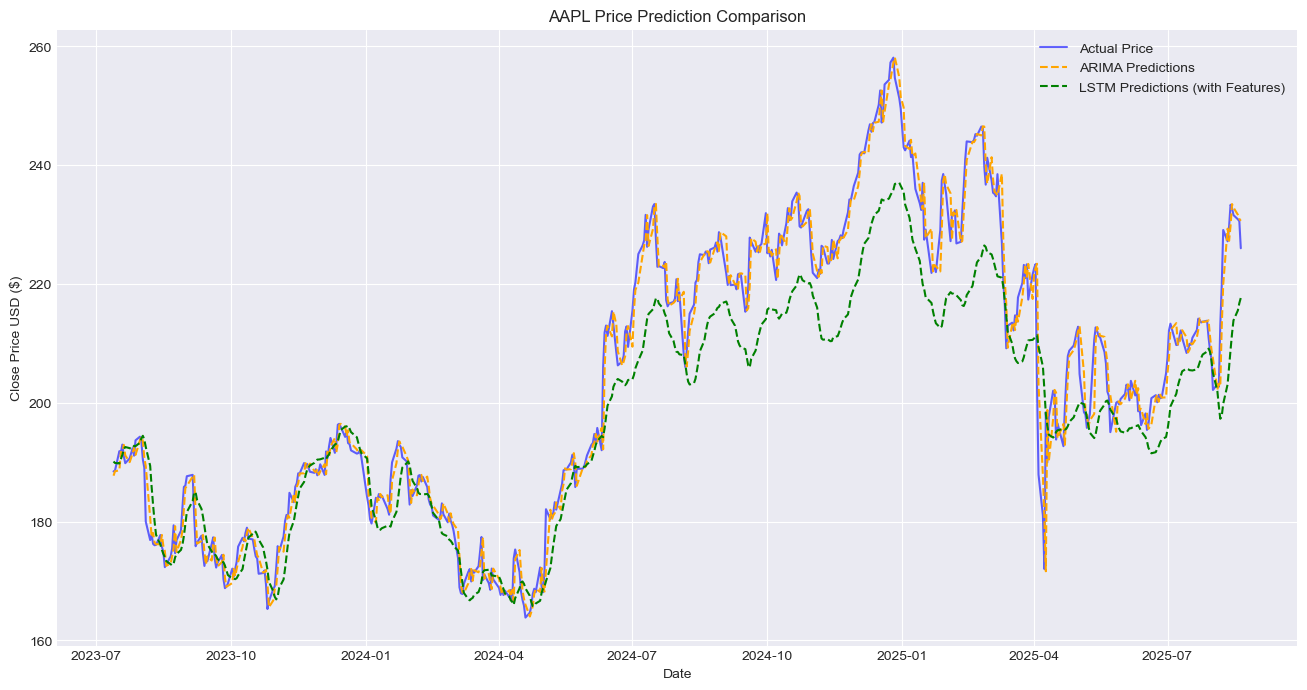

In [32]:
# ===================================================================
# Part 4: Final Comparison
# ===================================================================
print("\n\n================================================")
print("          Final Model Comparison          ")
print("================================================")
print(f"Stock Ticker: {STOCK_TICKER}")
print("------------------------------------------------")
print("  Metric                      |  ARIMA   |  LSTM  ")
print("------------------------------------------------")
print(f"Price Prediction RMSE         | {arima_rmse:^8.4f} | {lstm_rmse:^6.4f}")
print(f"Directional Accuracy          | {arima_accuracy:^8.4f} | {lstm_accuracy:^6.4f}")
print("================================================\n")


# ===================================================================
# Part 5: Visualization
# ===================================================================
plt.figure(figsize=(16, 8))
plt.title(f'{STOCK_TICKER} Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(test_data.index, test_data['Close'], label='Actual Price', color='blue', alpha=0.6)
plt.plot(test_data.index, predictions_arima, label='ARIMA Predictions', color='orange', linestyle='--')
plt.plot(results_df.index, results_df['LSTM_Prediction'], label='LSTM Predictions (with Features)', color='green', linestyle='--')
plt.legend()
plt.show()